# Objetivo

**Aluna:** Tathiana de Souza Martins
**Email:** tsm2@cesar.school

O objetivo deste projeto foi desenvolver uma rede neural através de um modelo pré-treinado, o VGG16, que tenha a capacidade de identificar tumores em imagens de Ressonância Magnética e Tomografia Computadorizada. Os dados utilizados para o treinamento foram baixados do [Kaggle]('https://www.kaggle.com/datasets/murtozalikhon/brain-tumor-multimodal-image-ct-and-mri') e consiste de imagens de cérebros com e sem tumor.

O conjunto de dados inclui imagens de TC e RM de alta resolução capturadas de vários pacientes, com cada imagem rotulada com o tipo de tumor correspondente (por exemplo, glioma, meningioma, etc.) e sua localização dentro do cérebro. Esta combinação de imagens de TC e RM visa alavancar os pontos fortes de ambas as técnicas de imagem: tomografias computadorizadas para visualização clara da estrutura óssea e RM para detalhes de tecidos moles, permitindo uma análise mais precisa de tumores cerebrais. Para mais informações sobre o dataset clique no link do Kaggle acima.

## Importando as bibliotecas

In [ ]:
import pandas as pd
import numpy as np
import os
import torch

In [ ]:
from PIL import Image, ImageOps
import matplotlib.pyplot as plt

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torchvision.models import vgg16, VGG16_Weights
from torch.utils.data import DataLoader, Subset, random_split
from tqdm import tqdm

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader
from torchvision.models import VGG16_Weights

## Baixando o dataset

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("murtozalikhon/brain-tumor-multimodal-image-ct-and-mri")

print("Path to dataset files:", path)

100%|██████████| 361M/361M [00:13<00:00, 28.8MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/murtozalikhon/brain-tumor-multimodal-image-ct-and-mri/versions/1


In [ ]:

print(os.listdir('/root/.cache/kagglehub/datasets/murtozalikhon/brain-tumor-multimodal-image-ct-and-mri/versions/1'))


['Dataset']


In [ ]:
!ls -a /root/.cache/kagglehub/datasets/murtozalikhon/brain-tumor-multimodal-image-ct-and-mri/versions/1

.  ..  Dataset


In [ ]:
# Caminho do dataset raiz
dataset_path = '/root/.cache/kagglehub/datasets/murtozalikhon/brain-tumor-multimodal-image-ct-and-mri/versions/1'


In [ ]:
# Detecta supastas e se tem imagens nelas
for item in os.listdir(dataset_path):
    item_path = os.path.join(dataset_path, item)
    if os.path.isdir(item_path):
        print(f"Subfolder: {item}, Contents: {os.listdir(item_path)}")

Subfolder: Dataset, Contents: ['Brain Tumor MRI images', 'Brain Tumor CT scan Images']


## Visualizando as imagens

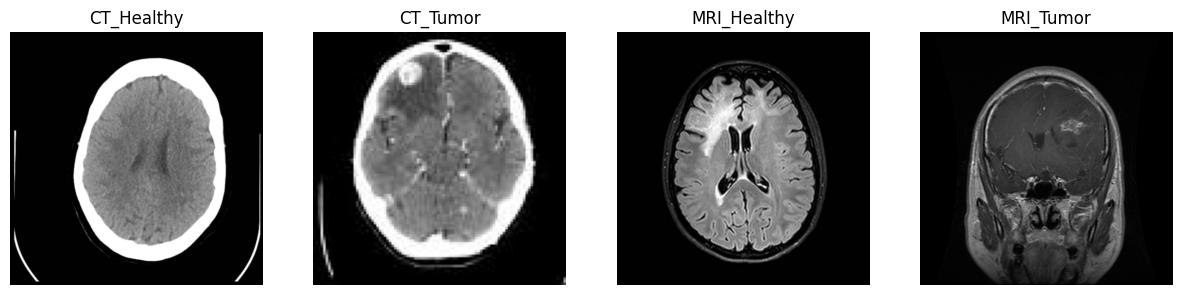

In [ ]:
# Lista das categorias principais e subcategorias
scan_categories = {
    "CT_Healthy": "Brain Tumor CT scan Images/Healthy",
    "CT_Tumor": "Brain Tumor CT scan Images/Tumor",
    "MRI_Healthy": "Brain Tumor MRI images/Healthy",
    "MRI_Tumor": "Brain Tumor MRI images/Tumor"
}

# Função para exibir uma imagem de cada categoria
def show_sample_images(dataset_path, scan_categories):
    plt.figure(figsize=(15, 10))
    for i, (category_name, category_path) in enumerate(scan_categories.items()):
        full_path = os.path.join(dataset_path, 'Dataset', category_path)

        if os.path.exists(full_path):
            # Selecionar uma imagem da subpasta
            image_file = [f for f in os.listdir(full_path) if f.lower().endswith(('png', 'jpg', 'jpeg'))][0]
            image_path = os.path.join(full_path, image_file)
            image = Image.open(image_path)

            # Exibir a imagem
            plt.subplot(1, len(scan_categories), i + 1)
            plt.imshow(image, cmap='gray')
            plt.title(category_name)
            plt.axis('off')
        else:
            print(f"Diretório não encontrado: {full_path}")
    plt.show()

# Caminho do dataset
dataset_path = '/root/.cache/kagglehub/datasets/murtozalikhon/brain-tumor-multimodal-image-ct-and-mri/versions/1'

# Chamar a função para exibir as imagens
show_sample_images(dataset_path, scan_categories)


## Funções de Treinamento

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
def train_model(model, trainloader, valloader, criterion, optimizer, device=device, num_epochs=5):
    history = {
        'train_losses': [],
        'val_losses': [],
        'train_accuracies': [],
        'val_accuracies': []
    }

    for epoch in range(num_epochs):
        # Treinamento
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for i, data in tqdm(enumerate(trainloader, 0), total=len(trainloader)):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(trainloader)
        train_acc = 100 * correct / total
        history['train_losses'].append(train_loss)
        history['train_accuracies'].append(train_acc)
        print(f'Epoch {epoch+1}, Train Loss: {train_loss:.3f}, Train Accuracy: {train_acc:.2f}%')

        # Validação
        model.eval()
        val_running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for data in valloader:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = val_running_loss / len(valloader)
        val_acc = 100 * correct / total
        history['val_losses'].append(val_loss)
        history['val_accuracies'].append(val_acc)
        print(f'Epoch {epoch+1}, Val Loss: {val_loss:.3f}, Val Accuracy: {val_acc:.2f}%')

    print('Treinamento concluído')
    return history


def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    ax1.plot(history['train_losses'], label='Train')
    ax1.plot(history['val_losses'], label='Validation')
    ax1.set_title('Loss')
    ax1.legend()

    ax2.plot(history['train_accuracies'], label='Train')
    ax2.plot(history['val_accuracies'], label='Validation')
    ax2.set_title('Accuracy')
    ax2.legend()

    plt.show()


def test_model(model, testloader, device=device):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Acurácia da rede na base de teste: {100 * correct / total:.2f}%')

## O modelo

### Baixando o modelo

In [ ]:
modelo = vgg16(weights=VGG16_Weights.IMAGENET1K_V1)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 145MB/s]


In [ ]:
# Carregar os pesos pré-treinados com o método recomendado
weights = VGG16_Weights.IMAGENET1K_V1

# Obter a transformação padrão para o modelo
preprocess = weights.transforms()

# Caminho do dataset
dataset_path = '/root/.cache/kagglehub/datasets/murtozalikhon/brain-tumor-multimodal-image-ct-and-mri/versions/1/Dataset'

# Transformações com aumento de dados para treino
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    preprocess
])

# Carregar o dataset completo sem transformação inicial
full_dataset = datasets.ImageFolder(root=dataset_path)  # Sem `transform`

# Divisão em treino (70%), validação (15%) e teste (15%)
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

# Reatribuir transformações aos subconjuntos
train_dataset.dataset = datasets.ImageFolder(root=dataset_path, transform=train_transforms)  # Transformações com aumento
val_dataset.dataset = datasets.ImageFolder(root=dataset_path, transform=preprocess)         # Apenas preprocess
test_dataset.dataset = datasets.ImageFolder(root=dataset_path, transform=preprocess)        # Apenas preprocess

# Criar DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


### Visualizando as camadas do modelo

In [ ]:
modelo

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### Ajustando as camadas para o nosso dataset

In [ ]:
# Congelar todas as camadas
for param in modelo.parameters():
    param.requires_grad = False

In [ ]:
# Substituir a última camada
modelo.classifier[6] = nn.Linear(modelo.classifier[6].in_features, 2) # ou modelo_vgg16.classifier[-1] para acessar a última camada
modelo = modelo.to(device)

In [ ]:
modelo

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### Treinando o modelo

*Lembrete: Usar GPU

100%|██████████| 211/211 [01:31<00:00,  2.30it/s]


Epoch 1, Train Loss: 0.050, Train Accuracy: 98.10%
Epoch 1, Val Loss: 0.027, Val Accuracy: 99.45%


100%|██████████| 211/211 [01:27<00:00,  2.42it/s]


Epoch 2, Train Loss: 0.023, Train Accuracy: 99.61%
Epoch 2, Val Loss: 0.023, Val Accuracy: 99.58%


100%|██████████| 211/211 [01:26<00:00,  2.45it/s]


Epoch 3, Train Loss: 0.021, Train Accuracy: 99.54%
Epoch 3, Val Loss: 0.023, Val Accuracy: 99.58%


100%|██████████| 211/211 [01:27<00:00,  2.41it/s]


Epoch 4, Train Loss: 0.016, Train Accuracy: 99.72%
Epoch 4, Val Loss: 0.023, Val Accuracy: 99.58%


100%|██████████| 211/211 [01:26<00:00,  2.44it/s]


Epoch 5, Train Loss: 0.016, Train Accuracy: 99.69%
Epoch 5, Val Loss: 0.022, Val Accuracy: 99.58%
Treinamento concluído


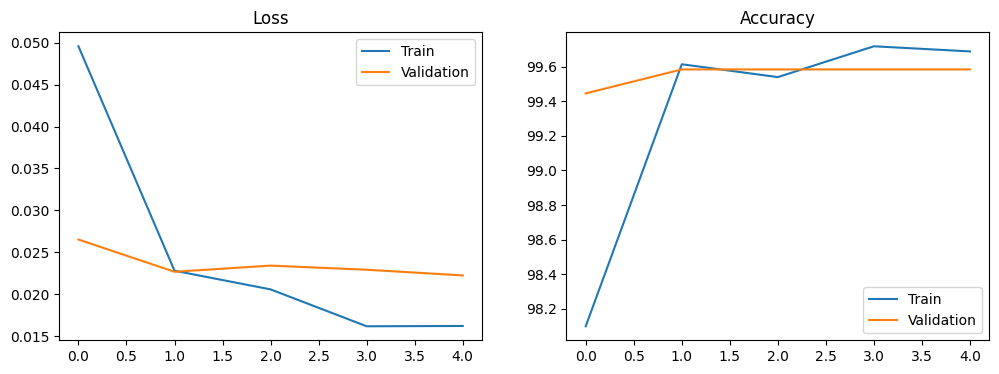

Acurácia da rede na base de teste: 99.58%


In [ ]:
# Treinando a CNN
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(modelo.parameters(), lr=0.001, momentum=0.9)

history = train_model(modelo, train_loader, val_loader, criterion, optimizer, device, num_epochs=5)

plot_history(history)
test_model(modelo, val_loader)

**Observações:**

* **Consistência entre Treino e Validação:**

* - A perda de validação (Val Loss) e a perda de treino (Train Loss) são muito próximas ao longo das épocas, indicando que o modelo não está memorizando os dados de treino (o que seria um sinal de overfitting).

* - A acurácia de validação (Val Accuracy) também é muito alta (99.58%) e estável após a primeira época, o que indica que o modelo está generalizando bem.


* **Estagnação da Val Loss e Val Accuracy:**

* - A Val Loss e a Val Accuracy não melhoram após a 2ª época, o que pode indicar que o modelo atingiu um ponto de saturação em termos de performance. Ele aprendeu o máximo que pode com os dados disponíveis.


* **Diferença Entre Métricas:**

* - A diferença entre Train Accuracy (99.69%) e Val Accuracy (99.58%) é muito pequena. Isso sugere que o modelo está bem equilibrado e não apresenta sinais claros de overfitting.

### Testando com dados externos

Este conjunto de dados consiste em exames de ressonância magnética categorizados em duas classes: "Sim" (tumor cerebral detectado) e "Não" (nenhum tumor cerebral detectado). Ele é estruturado para facilitar tarefas de classificação binária para análise de imagens médicas e pode servir como um recurso para treinar modelos de aprendizado profundo voltados para a identificação de tumores cerebrais a partir de exames de ressonância magnética.

[Kaggle]('https://www.kaggle.com/datasets/arifmia/brain-tumor-dataset')

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("arifmia/brain-tumor-dataset")

print("Path to dataset files:", path)

100%|██████████| 1.29M/1.29M [00:01<00:00, 1.31MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/arifmia/brain-tumor-dataset/versions/1


In [ ]:
external_dataset_path_1 = '/root/.cache/kagglehub/datasets/arifmia/brain-tumor-dataset/versions/1'

In [ ]:
# Carregar o conjunto de dados externo
external_dataset = datasets.ImageFolder(root=external_dataset_path_1)
print(external_dataset.classes)

['Brain MRI']


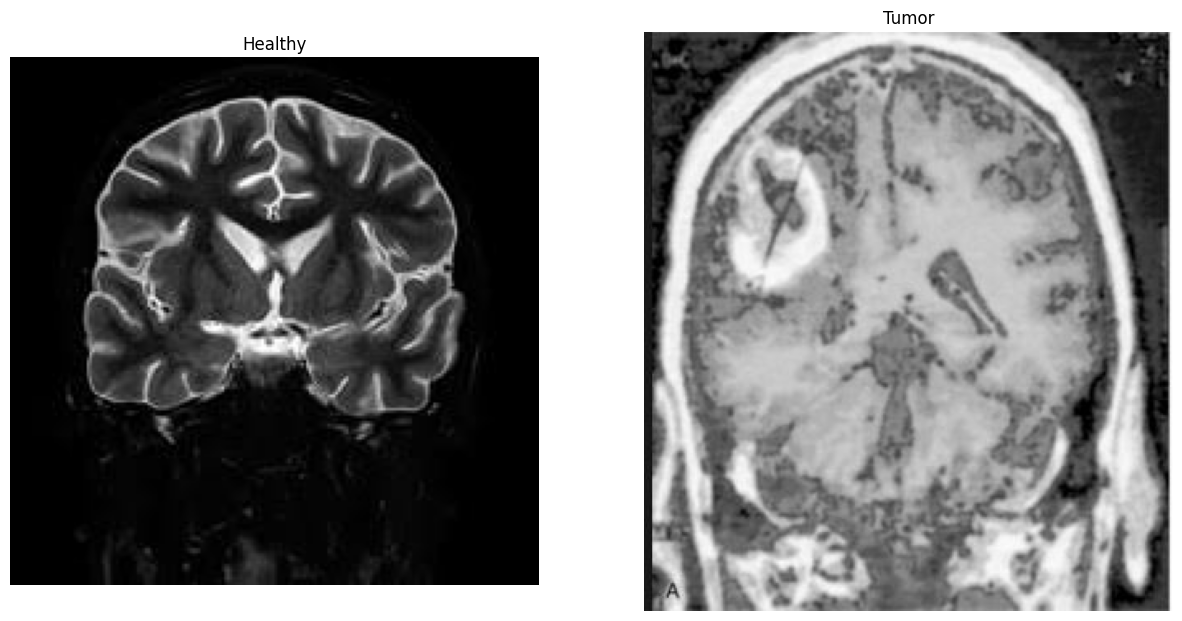

In [ ]:
# Lista das categorias principais e subcategorias
scan_categories = {
    'Healthy': 'no',
    'Tumor': 'yes',
}

# Função para exibir uma imagem de cada categoria
def show_sample_images(dataset_path, scan_categories):
    plt.figure(figsize=(15, 10))
    for i, (category_name, category_path) in enumerate(scan_categories.items()):
        full_path = os.path.join(dataset_path, 'Brain MRI', category_path)

        if os.path.exists(full_path):
            # Selecionar uma imagem da subpasta
            image_file = [f for f in os.listdir(full_path) if f.lower().endswith(('png', 'jpg', 'jpeg'))][0]
            image_path = os.path.join(full_path, image_file)
            image = Image.open(image_path)

            # Exibir a imagem
            plt.subplot(1, len(scan_categories), i + 1)
            plt.imshow(image, cmap='gray')
            plt.title(category_name)
            plt.axis('off')
        else:
            print(f"Diretório não encontrado: {full_path}")
    plt.show()

# Chamar a função para exibir as imagens
show_sample_images(external_dataset_path_1, scan_categories)


In [ ]:
import os
from torchvision import datasets
from torch.utils.data import DataLoader

# Caminho para os dados adicionais
external_dataset_path = '/root/.cache/kagglehub/datasets/arifmia/brain-tumor-dataset/versions/1/Brain MRI'

# Carregar o conjunto de dados externo
external_dataset = datasets.ImageFolder(root=external_dataset_path, transform=preprocess)

# Criar DataLoader para os dados externos
external_loader = DataLoader(external_dataset, batch_size=32, shuffle=False)

# Avaliar o modelo nos dados externos
print("Avaliando o modelo com o conjunto de dados externo...")
test_model(modelo, external_loader)


Avaliando o modelo com o conjunto de dados externo...
Acurácia da rede na base de teste: 56.90%


A acurácia baixa com dados externos pode ser porque as novas imagens sejam exclusivamente de ressonância magnética, sendo que o modelo fora treinado por imagens de tomografia computadorizada e RM. Ou pode ser que o modelo precise generalizar melhor o aprendizado, sendo necessário mais treinamento (mais dados, épocas, validação cruzada etc).